# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

# pip freeze > requirements.txt

# Create the Agent
from ddpg_td3_model import Agent



tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the 2nd agent looks like:', states[1])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]
The state for the 2nd agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):    
        # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


Total score (averaged over agents) this episode: 0.1064999976195395


When finished, you can close the environment.

### 4. Model selected: DDPG - TD3

Based on: https://spinningup.openai.com/en/latest/algorithms/td3.html

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

While DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function. Twin Delayed DDPG (TD3) is an algorithm which addresses this issue by introducing three critical tricks:

**Trick One:** Clipped Double-Q Learning. TD3 learns two Q-functions instead of one (hence “twin”), and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.

**Trick Two:** “Delayed” Policy Updates. TD3 updates the policy (and target networks) less frequently than the Q-function. The paper recommends one policy update for every two Q-function updates.

**Trick Three:** Target Policy Smoothing. TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.

![Model](https://spinningup.openai.com/en/latest/_images/math/52d3d2df4225f9fec06156d6e1d3da26c8b27bc5.svg)

#### Hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size  
BATCH_SIZE = 128        # minibatch size  
GAMMA = 0.995           # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR_ACTOR = 0.1e-3       # learning rate of the actor   
LR_CRITIC = 1e-3        # learning rate of the critic  
WEIGHT_DECAY = 1e-6     # L2 weight decay  

### 5. Training the agents

In [6]:
agent = Agent(state_size=state_size, 
              action_size=action_size, 
              random_seed=1, agent_size=num_agents)

Episode 1	Average Score: 0.62
Episode 2	Average Score: 0.57
Episode 3	Average Score: 0.69
Episode 4	Average Score: 0.88
Episode 5	Average Score: 0.89
Episode 6	Average Score: 0.85
Episode 7	Average Score: 0.92
Episode 8	Average Score: 1.07
Episode 9	Average Score: 1.17
Episode 10	Average Score: 1.31
Episode 11	Average Score: 1.44
Episode 12	Average Score: 1.57
Episode 13	Average Score: 1.77
Episode 14	Average Score: 1.90
Episode 15	Average Score: 2.04
Episode 16	Average Score: 2.17
Episode 17	Average Score: 2.36
Episode 18	Average Score: 2.58
Episode 19	Average Score: 2.78
Episode 20	Average Score: 3.04
Episode 21	Average Score: 3.28
Episode 22	Average Score: 3.61
Episode 23	Average Score: 3.86
Episode 24	Average Score: 4.08
Episode 25	Average Score: 4.32
Episode 26	Average Score: 4.64
Episode 27	Average Score: 4.93
Episode 28	Average Score: 5.22
Episode 29	Average Score: 5.44
Episode 30	Average Score: 5.72
Episode 31	Average Score: 6.03
Episode 32	Average Score: 6.43
Episode 33	Averag

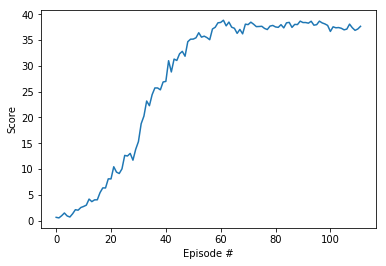

In [7]:
def ddpg_td3(n_episodes=1000, max_t=1000, consecutive_episodes = 100, 
             learn_every = 20, n_experiences = 20, target_avg_score = 30.0, print_every=1):
    """Deep Deterministic Policy Gradients DDPG  from Pendulum exercise was employed: 
       Params:
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            consecutive_episodes (int): number of consecutive episodes
            learn_every (int): update the network every n timesteps
            n_experiences (int): update the netword n times
            target_avg_score (int): target avg score of the range of n consecutive_episodes
            print_every (int): print the training every n timesteps
    """
    
    scores_windows = deque(maxlen=consecutive_episodes)
    scores = [] # list containing scores 
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations # get the current stat
        agent.reset() #initialize agents 
        agents_scores = np.zeros(num_agents) 
        
        for t in range(max_t):
            actions=[] # clear actions
            actions = agent.act(states) # select an action   
            action_info = env.step(actions)[brain_name] # get enviroment info
            next_states = action_info.vector_observations # get next state 
            rewards = action_info.rewards # get reward 
            dones = action_info.local_done # see if episode finished
            
            for index in range(0,num_agents):
                agent.save_experience(states[index], actions[index], rewards[index], next_states[index], dones[index])
                
            agent.multi_step(states, actions, rewards, next_states, dones) 
            
            states = next_states # roll over states to next time step
            agents_scores += rewards # update the scores
            
            agent.multi_learning(t, learn_every, n_experiences) #Train each agent 

            if np.any(dones):
                break 
 
        scores_windows.append(np.mean(agents_scores))
        scores.append(np.mean(agents_scores))         # save most recent score
        score_mean =np.mean(scores_windows)

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_mean), end="\n")   
       
        if np.mean(scores_windows)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_mean))
            torch.save(agent.actor_local.state_dict(),  'td3_actor.pth' )
            torch.save(agent.critic_local.state_dict(), 'td3_critic.pth')
            break
            
    return scores

scores = ddpg_td3()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Testing the agents

In [8]:
# Play the Trained Agent
# load the weights from file
agent.actor_local.load_state_dict(torch.load('td3_actor.pth'))
agent.critic_local.load_state_dict(torch.load('td3_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations              # get the current state (for each agent)
scores = np.zeros(num_agents)                      # initialize the score (for each agent)                                         # initialize the score
while True:
    actions = agent.act(states)                # select an action (for each agent)
    actions = np.clip(actions, -1, 1)          # all actions between -1 and 1      
    env_info = env.step(actions)[brain_name]   # send the action to the environment                  
    next_states =  env_info.vector_observations# get the next state (for each agent)
    rewards = env_info.rewards                 # get the reward (for each agent)
    dones =env_info.local_done                 # see if episode has finished
    scores += rewards                          # update the score (for each agent)
    states = next_states                       # roll over the state to next time step
    if np.any(dones):                          # exit loop if episode finished
        break
    
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 36.78049917789176


In [9]:
env.close()

I'd like to understand the implementation of the paper: **On-Policy Trust Region Policy Optimisation with Replay Buffers**, Dmitry Kangin, Nicolas Pugeault.

https://arxiv.org/abs/1901.06212
    
**Summary:**
    
Building upon the recent success of deep reinforcement learning methods, we investigate the possibility of on-policy reinforcement learning improvement by reusing the data from several consecutive policies. On-policy methods bring many benefits, such as ability to evaluate each resulting policy. However, they usually discard all the information about the policies which existed before. In this work, we propose adaptation of the replay buffer concept, borrowed from the off-policy learning setting, to create the method, combining advantages of on- and off-policy learning. To achieve this, the proposed algorithm generalises the Q-, value and advantage functions for data from multiple policies. The method uses trust region optimisation, while avoiding some of the common problems of the algorithms such as TRPO or ACKTR: it uses hyperparameters to replace the trust region selection heuristics, as well as the trainable covariance matrix instead of the fixed one. In many cases, the method not only improves the results comparing to the state-of-the-art trust region on-policy learning algorithms such as PPO, ACKTR and TRPO, but also with respect to their off-policy counterpart DDPG.    